# Write-Up

To: Mr Rooney

From: Kavan Wills

The goal I aimed to achieve was finding players who are valuable contributors but are paid less than players with similar performance. This improves the roster without costing a large amount of salary. To do so, I combined these two datasets:

1. NBA 2025 performance statistics (how much a player plays and what they produce).

2. 2025–26 salary data (how much each player is paid)

Before combining them, I removed duplicate entries and cleaned player names to ensure the data was usable and accurate.

From these datasets, I grouped players based on multiple performance measures to compare each player to similar players using a method called KMeans clustering. The performance measures used include:

* Minutes per game (how much they’re trusted to play)

* Points, assists, rebounds, steals, blocks, and turnovers per game

* Shooting efficiency metrics (overall efficiency and accuracy)

I scaled these variables before clustering them so that stats with larger numbers don't dominate the others.

In order to find the best players, I computed the typical salary within each of the performance groups, then compared each player's salary to that group's average. This is the salary residual, which is calculated by the following equation:

Salary residual = player salary − average salary of similar performers

* If the residual is negative, the player is paid less than typical for that performance level → good value.

* If the residual is positive, the player is paid more than typical for that performance level → bad value.

To keep recommendations realistic, I filtered to rotation players (players who actually play meaningful minutes and enough games). This avoids recommending “cheap” players who aren’t actually contributing.

Below is a visualization of the KMeans clustering:

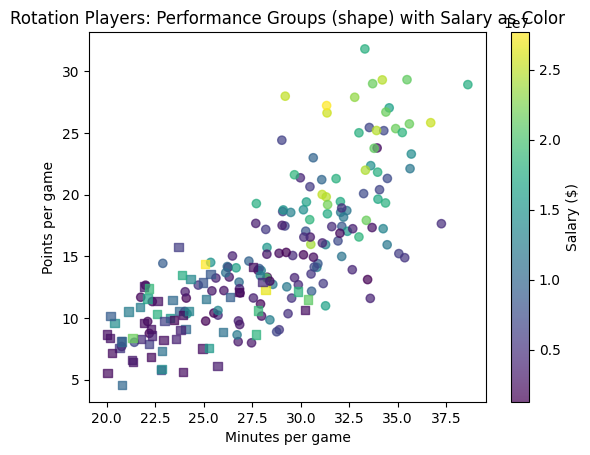

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

stats = pd.read_csv("nba_2025.txt", sep=",", encoding="latin-1")
salary = pd.read_csv("2025_salaries.csv", header=1, encoding="latin-1")

salary["Player"] = salary["Player"].astype(str).str.encode("latin-1", "ignore").str.decode("latin-1").str.strip()
stats["Player"]  = stats["Player"].astype(str).str.encode("latin-1", "ignore").str.decode("latin-1").str.strip()

salary["Salary"] = salary["2025-26"].astype(str).str.replace(r"[^0-9.\-]", "", regex=True).replace("", np.nan).astype(float)
salary = salary.groupby("Player", as_index=False).agg({"Tm": "first", "Salary": "max"})
stats = stats.drop_duplicates(subset="Player", keep="first")

merged_data = pd.merge(salary, stats, on="Player", how="inner")

for col in ["G","MP","PTS","AST","TRB","STL","BLK","TOV","eFG%","3P%","FT%"]:
    merged_data[col] = pd.to_numeric(merged_data[col], errors="coerce")

merged_data["MP_pg"]  = merged_data["MP"]  / merged_data["G"]
merged_data["PTS_pg"] = merged_data["PTS"] / merged_data["G"]
merged_data["AST_pg"] = merged_data["AST"] / merged_data["G"]
merged_data["TRB_pg"] = merged_data["TRB"] / merged_data["G"]
merged_data["STL_pg"] = merged_data["STL"] / merged_data["G"]
merged_data["BLK_pg"] = merged_data["BLK"] / merged_data["G"]
merged_data["TOV_pg"] = merged_data["TOV"] / merged_data["G"]

features = ["MP_pg","PTS_pg","AST_pg","TRB_pg","STL_pg","BLK_pg","TOV_pg","eFG%","3P%","FT%"]
X = merged_data[features].fillna(merged_data[features].mean(numeric_only=True))
X_scaled = StandardScaler().fit_transform(X)

merged_data["cluster"] = KMeans(n_clusters=2, random_state=42, n_init=20).fit_predict(X_scaled)

pool = merged_data[(merged_data["MP_pg"] >= 20) & (merged_data["G"] >= 25)].copy()

plt.figure()
markers = ["o","s","^","D","P","X","*","v"]
for cl in sorted(pool["cluster"].unique()):
    sub = pool[pool["cluster"] == cl]
    plt.scatter(sub["MP_pg"], sub["PTS_pg"], c=sub["Salary"], marker=markers[int(cl) % len(markers)], alpha=0.7)
plt.xlabel("Minutes per game")
plt.ylabel("Points per game")
plt.title("Rotation Players: Performance Groups (shape) with Salary as Color")
cb = plt.colorbar()
cb.set_label("Salary ($)")
plt.show()


In this visualization, each dot is a player. The x-axis shows minutes per-game, and the y-axis shows points per game. The shape of each dot shows which performance group the player is in, and the color corresponds to the player's salary. What we want is players who are productive (high minutes and points) but also have a low salary, so that purple/blue color.

This outlines the goal we want to achieve. Using this process, here's my final visualization of the players I do and dont recommend for your team:

In [16]:
pool = merged_data[(merged_data["MP_pg"] >= 20) & (merged_data["G"] >= 25)].copy()

pool["cluster_avg_salary"] = pool.groupby("cluster")["Salary"].transform("mean")
pool["salary_residual"] = pool["Salary"] - pool["cluster_avg_salary"]

p10, p25, p90 = pool["salary_residual"].quantile([0.10, 0.25, 0.90])

good_choices = pool[pool["salary_residual"] <= p10].nsmallest(4, "salary_residual")
could_work_choices = pool[(pool["salary_residual"] > p10) & (pool["salary_residual"] <= p25)].nsmallest(4, "salary_residual")
not_good_choices = pool[pool["salary_residual"] >= p90].nlargest(4, "salary_residual")

cols = ["Player","Tm","Salary","cluster","cluster_avg_salary","salary_residual","MP_pg","PTS_pg","AST_pg","TRB_pg","eFG%"]

print("\n--- NOT GOOD choices ---")
display(not_good_choices[cols])

print("\n--- GOOD choices ---")
display(good_choices[cols])

print("\n--- COULD WORK choices ---")
display(could_work_choices[cols])


--- NOT GOOD choices ---


,Player,Tm,Salary,cluster,cluster_avg_salary,salary_residual,MP_pg,PTS_pg,AST_pg,TRB_pg,eFG%
364,Stephen Curry,GSW,59606817.0,0,2.120528e+07,3.840153e+07,31.333333,27.205128,4.846154,3.538462,0.585
205,Joel Embiid,PHI,55224526.0,0,2.120528e+07,3.401924e+07,31.354839,26.612903,3.903226,7.483871,0.528
244,Kevin Durant,HOU,54708609.0,0,2.120528e+07,3.350333e+07,36.700000,25.820000,4.440000,5.340000,0.570
135,Giannis Antetokounmpo,MIL,54126450.0,0,2.120528e+07,3.292117e+07,29.200000,27.966667,5.600000,10.033333,0.660



--- GOOD choices ---


,Player,Tm,Salary,cluster,cluster_avg_salary,salary_residual,MP_pg,PTS_pg,AST_pg,TRB_pg,eFG%
379,Toumani Camara,POR,2221677.0,0,2.120528e+07,-1.898361e+07,33.446429,13.107143,2.571429,5.357143,0.564
45,Brandon Williams,DAL,2270735.0,0,2.120528e+07,-1.893455e+07,22.000000,12.652174,3.673913,2.891304,0.494
75,Collin Gillespie,PHO,2296274.0,0,2.120528e+07,-1.890901e+07,28.277778,13.296296,4.685185,4.166667,0.576
348,Russell Westbrook,SAC,2296274.0,0,2.120528e+07,-1.890901e+07,29.250000,15.307692,6.576923,5.692308,0.509



--- COULD WORK choices ---


,Player,Tm,Salary,cluster,cluster_avg_salary,salary_residual,MP_pg,PTS_pg,AST_pg,TRB_pg,eFG%
50,Bub Carrington,WAS,4677600.0,0,2.120528e+07,-1.652768e+07,27.981132,10.150943,4.566038,3.528302,0.520
247,Kevin Porter Jr.,MIL,5134000.0,0,2.120528e+07,-1.607128e+07,33.678571,17.321429,7.607143,5.214286,0.500
99,Derik Queen,NOP,5157960.0,0,2.120528e+07,-1.604732e+07,26.036364,12.218182,4.145455,7.218182,0.506
256,Kris Dunn,LAC,5426400.0,0,2.120528e+07,-1.577888e+07,27.462963,7.981481,3.425926,2.888889,0.564


1) NOT GOOD choices

These are good players, but their contracts are extremely large compared to the typical pay for similar performance. For your situation, Mr. Rooney, these are players to avoid.

2) GOOD choices

These players stand out as being paid below what similar performers typically earn. These are the financially efficient players that my work has recommended for you.

3) COULD WORK

If the GOOD players are unattainable, these players are the next best option. They still provide positive value relative to their performance group.

In conclusion, I'd go for Toumani Camara, Brandon Williams, Collin Gillespie, and Russell Westbrook. If they aren't available, I'd go for Bub Carrington, Kevin Porter Jr., Derik Queen, and Kris Dunn.